# Dark diversity Proof of Concept testing

This notebook contains the tests and simulations conducted to test how dark diversity can be modelled and spatially interpolated.

DarkDiv is (currently) the best package for calculating dark diversity from species co-occurrences, authored by [Carmona and Pärtel (2020)](https://onlinelibrary.wiley.com/doi/10.1111/geb.13203). 

The R package DarkDiv can calculate dark diversity using multiple methods, including the previously leading Beals index, and the currently best performing hypergeometric method.

## Method summary

To test the DarkDiv package and spatial interpolation, we will start by generating 3 species distributions. These species distributions represent the full species pool, from which all species are present as they should be, with no dark diversity.

Then an artifical spatial restriction will be applied, where the species will be absent from some sites, though remain in the species pool. This will be the dark diversity. 

Drawing from the restricted species distributions, we will sample multiple plots, and calculate the dark diversity using the DarkDiv package. The expected dark diversity is known, and we will compare the calculated dark diversity to the expected dark diversity.

We will then use an environmental matching method to interpolate the dark diversity probabilities across the landscape.

In [2]:
library(ggplot2)
library(terra)
library(tidyr)
library(dplyr)
library(DarkDiv)
library(gamm4)
set.seed(123)

terra 1.8.29


Attaching package: 'tidyr'


The following object is masked from 'package:terra':

    extract



Attaching package: 'dplyr'


The following objects are masked from 'package:terra':

    intersect, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loading required package: lme4

Loading required package: mgcv

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:lme4':

    lmList


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

This is gamm4 0.2-6




# 1. Generating 3 species distributions

Environmental data is cropped and subset from the CHELSA data. This data has been used simply because it provides more spatial structure than a artifically generated dataset. Source data values themselves are irrelevant.

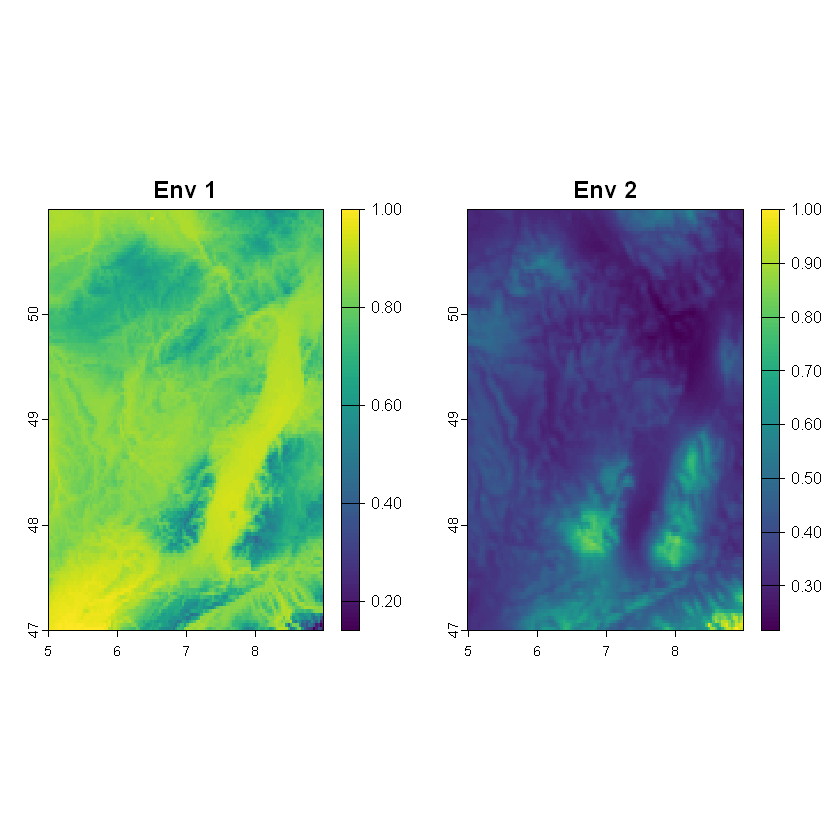

In [3]:
# This uses cropped data from CHELSA bio1 and bio12 for central Europe
env_1 <- terra::rast("sim_data_chelsa\\bio1.tif") |> terra::aggregate(4)
env_2 <- terra::rast("sim_data_chelsa\\bio12.tif") |> terra::aggregate(4)

env_1_ext <- terra::ext(env_1)

# Rescale the values to be between 0 and 100
env_1 <- env_1 / max(values(env_1))
env_2 <- env_2 / max(values(env_2))

par(bg = "white", mfrow = c(1, 2))  # Set the background color and layout
# Use image to create the heatmap

plot(env_1, main = "Env 1")
plot(env_2, main = "Env 2")

The species response to the environmental data is defined as a gaussian function. This has been done so that the distributions are known and can be defined such that species A and B have similar environmental responses, and species C is more different.

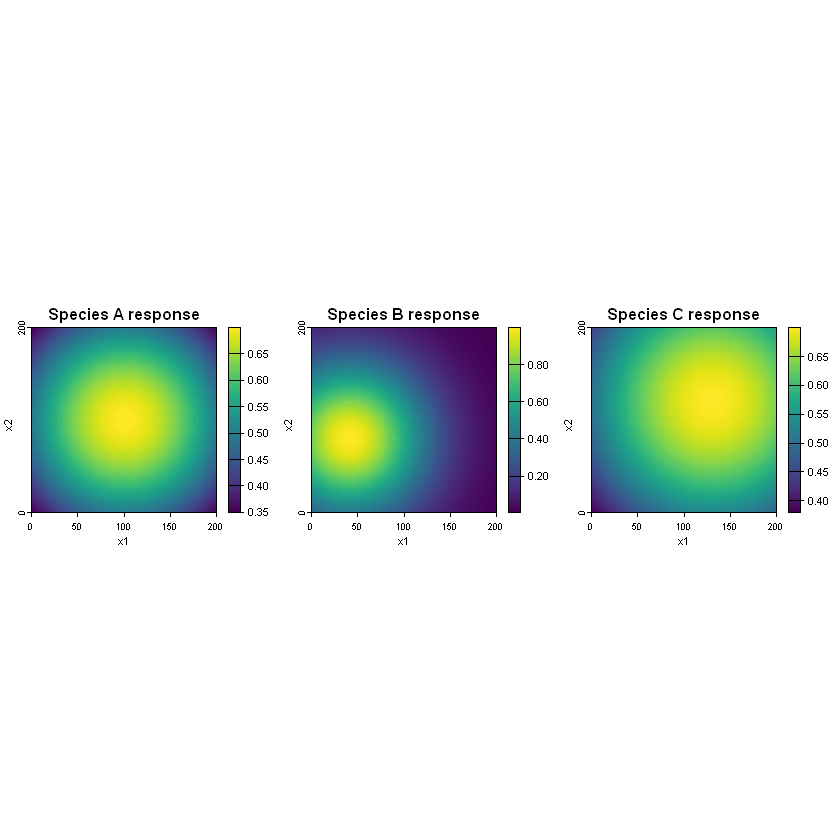

In [4]:
# Generate species response to environmental gradients

species_a <- function(x1, x2) {
  exp(-((x1 - 0.5)^2 + (x2 - 0.5)^2) / (2 * 0.6^2)) * 0.7
}

species_b <- function(x1, x2) {
  exp(-((x1 - 0.6)^2 + (x2 - 0.2)^2) / (2 * 0.3^2)) * 1 # Slightly shifted and narrower
}

species_c <- function(x1, x2) {
  exp(-((x1 - 0.4)^2 + (x2 - 0.65)^2) / (2 * 0.8^2)) * 0.7 # Quite different peak location
}

# Visualising the relationships
# Create a grid of x1 and x2 values
x1_vals <- seq(0, 1, length.out = 200)
x2_vals <- seq(0, 1, length.out = 200)
grid <- expand.grid(x1 = x1_vals, x2 = x2_vals)

# Calculate the function values for each species
species_a_response <- species_a(grid$x1, grid$x2)
species_b_response <- species_b(grid$x1, grid$x2)
species_c_response <- species_c(grid$x1, grid$x2)

# Visualize using contour plots with white backgrounds
par(mfrow = c(1, 3), bg = "white") # Set background to white for all plots

plot(
    terra::rast(
        matrix(species_a_response, nrow = length(x1_vals))
    ),
    main = "Species A response", 
    xlab = "x1", 
    ylab = "x2"
)
plot(
    terra::rast(
        matrix(species_b_response, nrow = length(x1_vals))
    ),
    main = "Species B response", 
    xlab = "x1", 
    ylab = "x2"
)
plot(
    terra::rast(
        matrix(species_c_response, nrow = length(x1_vals))
    ),
    main = "Species C response", 
    xlab = "x1", 
    ylab = "x2"
)


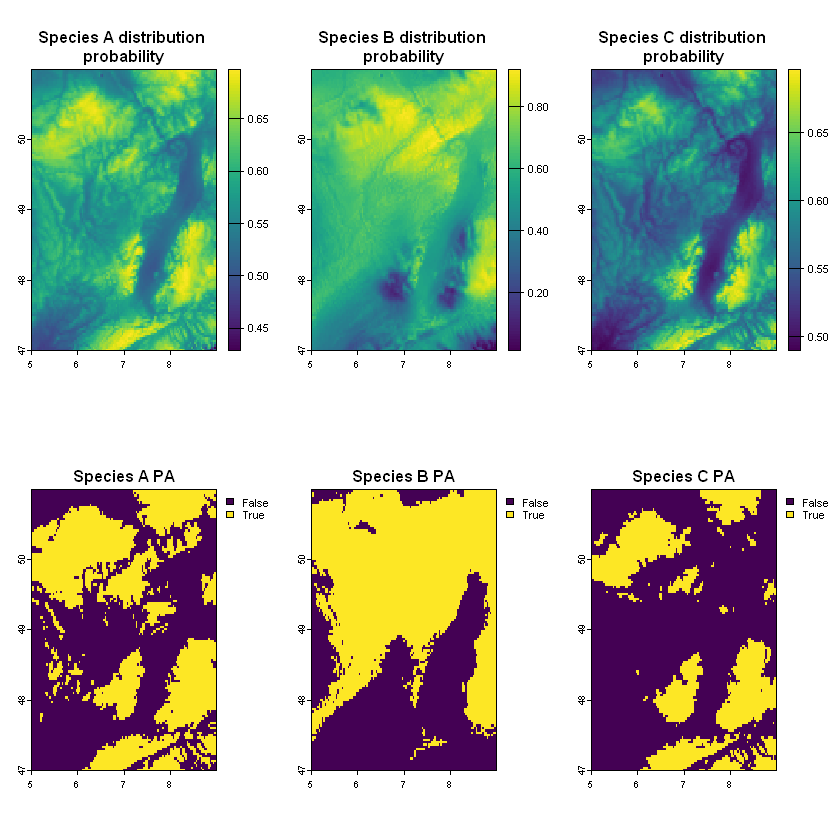

In [5]:
# Generate the species distributions
true_a_dist_prob <- species_a(env_1, env_2)
true_b_dist_prob <- species_b(env_1, env_2)
true_c_dist_prob <- species_c(env_1, env_2)

# Thresholded distributions
threshold <- 0.6

true_a_pa <- true_a_dist_prob > threshold
true_b_pa <- true_b_dist_prob > threshold
true_c_pa <- true_c_dist_prob > threshold

# Visualize the species distributions
par(mfrow = c(2, 3), bg = "white") # Set background to white for all plots
plot(true_a_dist_prob, main = "Species A distribution \nprobability")
plot(true_b_dist_prob, main = "Species B distribution \nprobability")
plot(true_c_dist_prob, main = "Species C distribution \nprobability")

plot(true_a_pa, main = "Species A PA")
plot(true_b_pa, main = "Species B PA")
plot(true_c_pa, main = "Species C PA")



The `dark_env` data represents an artificial restriction to species distribution, representing the drivers of dark diversity in reality. This is a simple factor that excludes species A and C from the landscape, similar to land use change or habitat destruction.

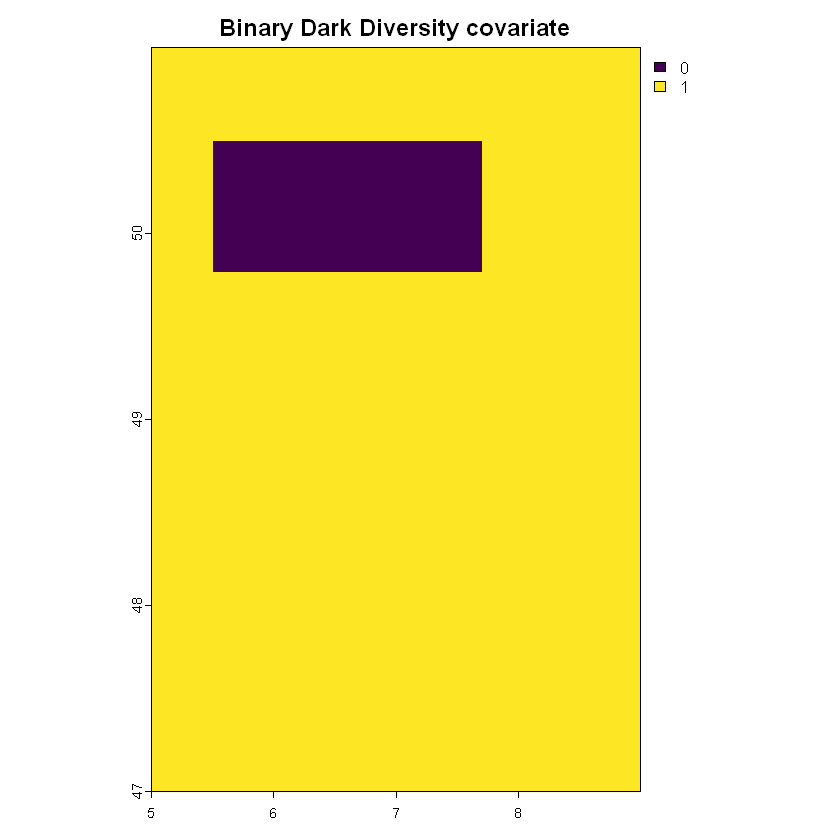

In [6]:
dark_env <- env_1 * 0
true_ext <- terra::ext(5.5, 7.7, 49.8, 50.5)
dark_env[true_ext] <- 1
dark_env <- 1 - dark_env

par(bg = "white") # Set the background color and layout
plot(dark_env, main = "Binary Dark Diversity covariate")

envs <- c(env_1, env_2, dark_env)
names(envs) <- c("env_1", "env_2", "dark_env")


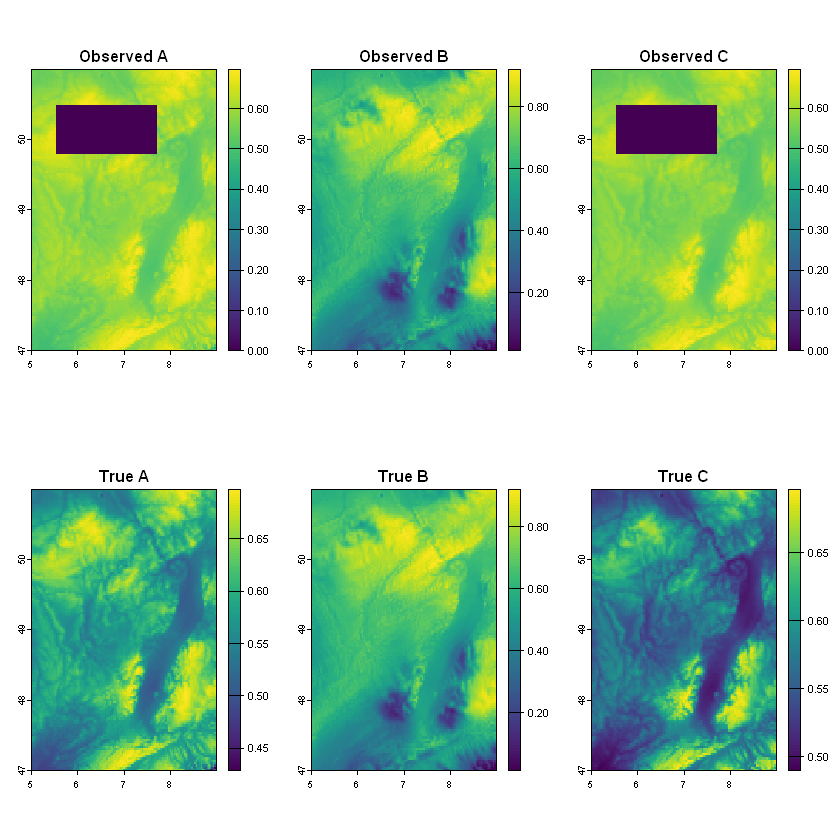

In [7]:
# Apply the dark diversity covariate to the species distributions

dark_env_impact <- function(species_prob_matrix, dd_env_2) {
    impacted_matrix <- species_prob_matrix * dd_env_2 
    return(impacted_matrix)
}

obs_a_dist_prob <- dark_env_impact(true_a_dist_prob, dark_env)
# Species B is not impacted by the dark diversity covariate
obs_b_dist_prob <- true_b_dist_prob
obs_c_dist_prob <- dark_env_impact(true_c_dist_prob, dark_env)

par(bg = "white", mfrow = c(2, 3))  # Set the background color and layout

plot(obs_a_dist_prob, main = "Observed A")
plot(obs_b_dist_prob, main = "Observed B")
plot(obs_c_dist_prob, main = "Observed C")
plot(true_a_dist_prob, main = "True A")
plot(true_b_dist_prob, main = "True B")
plot(true_c_dist_prob, main = "True C")

The true dark diversity is calculated from the `dark_env` data, where the probability of being in the dark diversity is the true probability multiplied by one minus the observed probability.

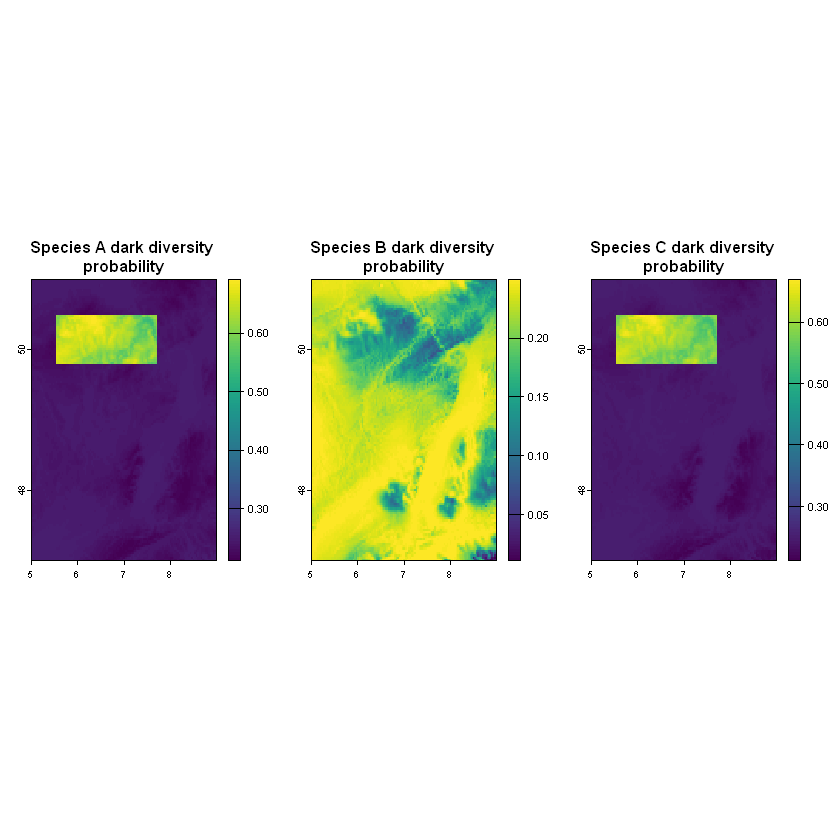

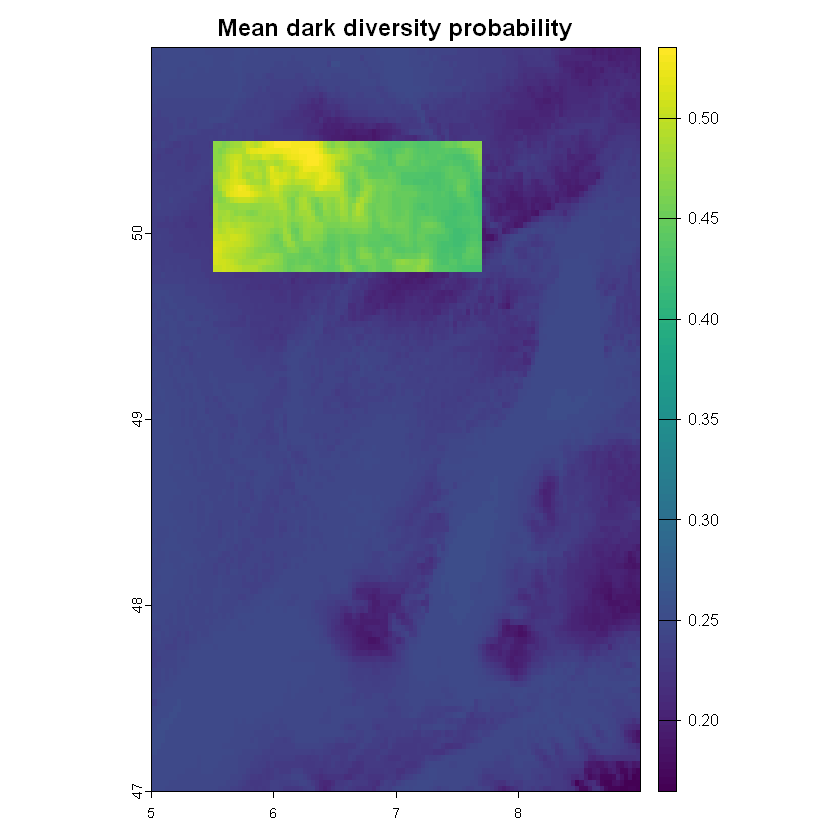

In [8]:
# Calculate the true dark diversity

# Probability each species is in the dark diversity
prob_missing_a <- true_a_dist_prob * (1 - obs_a_dist_prob)
prob_missing_b <- true_b_dist_prob * (1 - obs_b_dist_prob)
prob_missing_c <- true_c_dist_prob * (1 - obs_c_dist_prob)

par(bg = "white", mfrow = c(1, 3)) # Set the background color and layout

plot(prob_missing_a, main = "Species A dark diversity \nprobability")
plot(prob_missing_b, main = "Species B dark diversity \nprobability")
plot(prob_missing_c, main = "Species C dark diversity \nprobability")

# Take the mean of the probabilities for each species being in the dark diversity
dark_diversity_probability <- (prob_missing_a + prob_missing_b + prob_missing_c) / 3


par(mfrow = c(1, 1))
# Plot the number of missing values in each cell
plot(dark_diversity_probability, main = "Mean dark diversity probability")

# 2. Generating the observations

100 points are sampled across the landscape, representing species plot observations in vegetation sampling surveys.

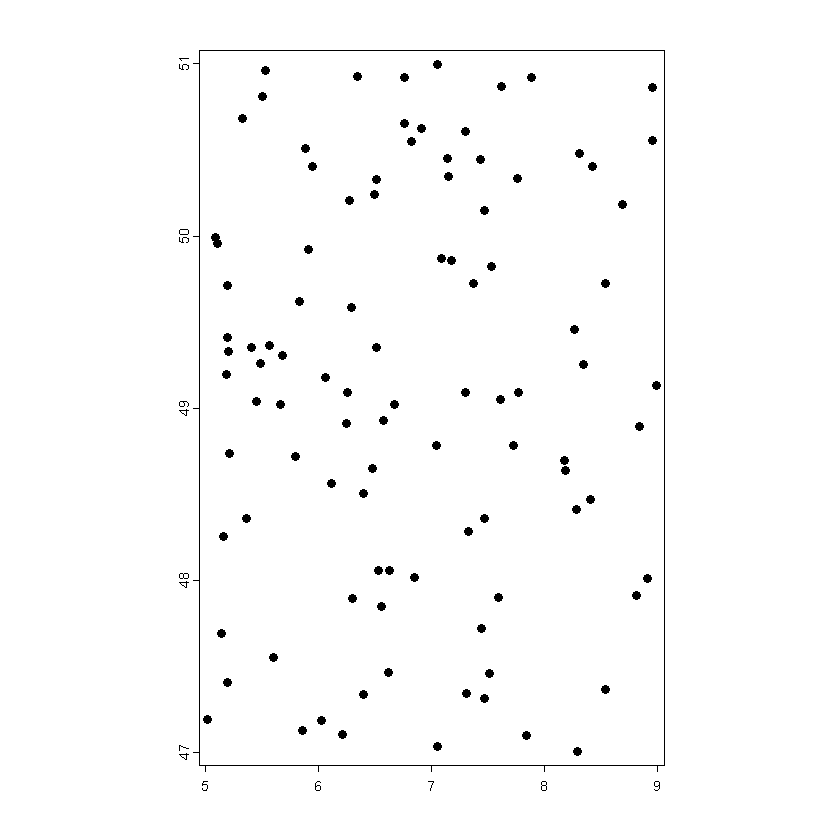

In [9]:
all_plots <- data.frame(
    x = runif(100000, env_1_ext[1], env_1_ext[2]),
    y = runif(100000, env_1_ext[3], env_1_ext[4])
) |> terra::vect(geom = c("x", "y"))


# Number of plots to use so we can easily change it
n_plots <- 100

plots <- sample(all_plots, n_plots)

par(bg = "white")
plot(plots)

In [10]:
# Get observations

# Sample observations from the real presence absence
species_a_obs <- ifelse(terra::extract(obs_a_dist_prob, plots)[, 2] > threshold, 1, 0)
species_b_obs <- ifelse(terra::extract(obs_b_dist_prob, plots)[, 2] > threshold, 1, 0)
species_c_obs <- ifelse(terra::extract(obs_c_dist_prob, plots)[, 2] > threshold, 1, 0)

# Simulate species frequency at each point by getting the probability, multiplying by 10 and rounding, then subtracting 5
# to only have observations where it very likely to be present
positive_or_zero <- function(x) {
  if (x > 0) {
    return(x)
  } else {
    return(0)
  }
}
species_a_freq <- round(terra::extract(true_a_dist_prob, plots)[, 2] * 10) - 5
species_a_freq <- sapply(species_a_freq, positive_or_zero)
species_b_freq <- round(terra::extract(true_b_dist_prob, plots)[, 2] * 10) - 5
species_b_freq <- sapply(species_b_freq, positive_or_zero)
species_c_freq <- round(terra::extract(true_c_dist_prob, plots)[, 2] * 10) - 5
species_c_freq <- sapply(species_c_freq, positive_or_zero)

env_1_obs <- terra::extract(env_1, plots)[, 2]
env_2_obs <- terra::extract(env_2, plots)[, 2]
dark_env_obs <- terra::extract(dark_env, plots)[, 2]

# Create a data frame with the observations
plot_observations <- data.frame(
    species_a_pa = species_a_obs,
    species_b_pa = species_b_obs,
    species_c_pa = species_c_obs,
    speices_a_freq = species_a_freq,
    species_b_freq = species_b_freq,
    species_c_freq = species_c_freq,
    env_1 = env_1_obs,
    env_2 = env_2_obs,
    dark_env = dark_env_obs
)

head(plot_observations)


,species_a_pa,species_b_pa,species_c_pa,speices_a_freq,species_b_freq,species_c_freq,env_1,env_2,dark_env
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,0,1,4,1,0.7456372,0.2617893,0
2,0,1,0,1,1,0,0.8699101,0.3378584,1
3,1,0,1,1,0,1,0.7292438,0.5993950,1
4,1,1,1,1,1,1,0.7408778,0.4552898,1
5,1,0,1,1,0,2,0.5970386,0.7712014,1
6,0,1,0,1,2,1,0.8180856,0.3686298,1


Using the `DarkDiv` package, the dark diversity across each point is calculated using the hypergeometric method. This returns a probability value for each species at each point based on the co-occurrences of other species. 

Where no species is present, the probability returned is defined to be exactly 0, though originally the package returns `NaN`. 

Where the species is observed, the dark diversity probability is by definition 0, as the species is observed, and so the function returns `NA`. We leave this `NA` as is.

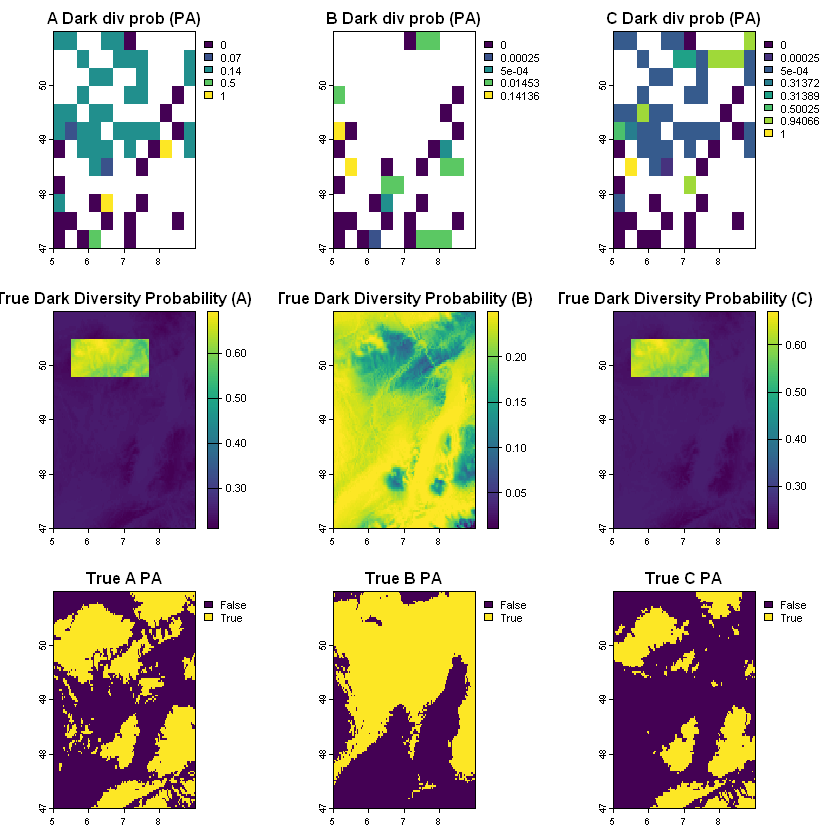

In [11]:
# Calculate the dark diversity probability for each plot

# Using PA
dd_pa <- DarkDiv::DarkDiv(plot_observations[1:3])$Dark
dd_pa_zerofilled <- ifelse(is.nan(dd_pa), 0, dd_pa)

colnames(dd_pa_zerofilled) <- c("sp_a_dark_prob", "sp_b_dark_prob", "sp_c_dark_prob")

# Using frequency
dd_freq <- DarkDiv::DarkDiv(plot_observations[4:6])$Dark
dd_freq_zerofilled <- ifelse(is.nan(dd_freq), 0, dd_freq)

plots$dd_pa_a <- dd_pa_zerofilled[,1]
plots$dd_pa_b <- dd_pa_zerofilled[,2]
plots$dd_pa_c <- dd_pa_zerofilled[,3]
plots$dd_freq_a <- dd_freq_zerofilled[,1]
plots$dd_freq_b <- dd_freq_zerofilled[,2]
plots$dd_freq_c <- dd_freq_zerofilled[,3]

template_rast <- terra::aggregate(env_1, 10)

# Plotting the point estimates for dark diversity probability for each species
sp_a_dd_pa_raster <- terra::rasterize(plots,template_rast, field = "dd_pa_a", fun = function(x) mean(x, na.rm = TRUE))
sp_b_dd_pa_raster <- terra::rasterize(plots,template_rast, field = "dd_pa_b", fun = function(x) mean(x, na.rm = TRUE))
sp_c_dd_pa_raster <- terra::rasterize(plots, template_rast, field = "dd_pa_c", fun = function(x) mean(x, na.rm = TRUE))

par(bg = "white", mfrow = c(3, 3))  # Set the background color and layout
plot(sp_a_dd_pa_raster, main = "A Dark div prob (PA)")
plot(sp_b_dd_pa_raster, main = "B Dark div prob (PA)")
plot(sp_c_dd_pa_raster, main = "C Dark div prob (PA)")

# Plotting the true dark diversity probability for comparison
plot(prob_missing_a, main = "True Dark Diversity Probability (A)")
plot(prob_missing_b, main = "True Dark Diversity Probability (B)")
plot(prob_missing_c, main = "True Dark Diversity Probability (C)")

# Plotting the species presence absense
plot(true_a_pa, main = "True A PA")
plot(true_b_pa, main = "True B PA")
plot(true_c_pa, main = "True C PA")


# 3. Spatially interpolating the dark diversity

Now that we have the point estimates for dark diversity using the DarkDiv package, we will use environmental matching to interpolate the dark diversity across the landscape.

The idea is that for each species and its dark diversity probability point estimates, the probability that it will be in the dark diversity will be similar where the environment is similar. 


## 3.1 Using K-Nearest Neighbours (in environmental space)
1. Extract Environmental Values:
    - Extract the values of `env_1`, `env_2`, and `dark_env` (if you're using it) at the locations of your dd_prob_estimates points. Store these in a matrix or data frame called env_data_training.
    - Extract the values of env_1, env_2, and dark_env at the locations of your prediction_grid points. Store these in a matrix or data frame called env_data_prediction.

2. Calculate Environmental Distances: For each point in prediction_grid, calculate the environmental distance to every point in dd_prob_estimates. You can use Euclidean distance, Mahalanobis distance, or another appropriate distance metric. The dist() function in R can calculate Euclidean distances. For Mahalanobis distance, you'll need the mahalanobis() function.

3. Identify K-Nearest Neighbors: For each point in prediction_grid, identify the k nearest neighbors in dd_prob_estimates based on the environmental distances you calculated. Choose a value for k (e.g., 5, 10, 20). The optimal value of k can be determined through cross-validation.

4. Calculate Weighted Average: For each point in prediction_grid, calculate a weighted average of the dark diversity probabilities of its k nearest neighbors. The weights can be based on the inverse of the environmental distances (closer neighbors get higher weights). Alternatively, you can use a simple unweighted average.

5. Assign Predicted Values: Assign the calculated weighted average dark diversity probability to each point in prediction_grid.

The idea is that similar points will have similar dark diversity probabilities. KNN finds the K locations in the training data that are the most similar 

In [12]:
# Data frame of observations, environmental variables and dark diversity probabilities
full_obs <- cbind(plot_observations, dd_pa_zerofilled)
# head(full_obs)

pred_raster <- terra::rast(ext(env_1), resolution = res(env_1))
terra::values(pred_raster) <- 0
prediction_grid <- terra::as.points(pred_raster)

# Extract environmental variables for prediction grid and observations
env_vars_pred <- terra::extract(c(env_1, env_2, dark_env), prediction_grid)[,-1]
env_vars_obs <- terra::extract(c(env_1, env_2, dark_env), plots)[,-1]

distances <- matrix(NA, nrow = nrow(prediction_grid), ncol = nrow(plot_observations))
distances_with_dark <- distances
for (i in 1:nrow(prediction_grid)) {
    for (j in 1:nrow(plot_observations)) {
        # Calculate distance with and without the dark diversity covariate
        distances[i, j] <- dist(rbind(env_vars_pred[i, -3], env_vars_obs[j, -3]))
        distances_with_dark[i, j] <- dist(rbind(env_vars_pred[i, ], env_vars_obs[j, ]))
    }
}

# head(distances)

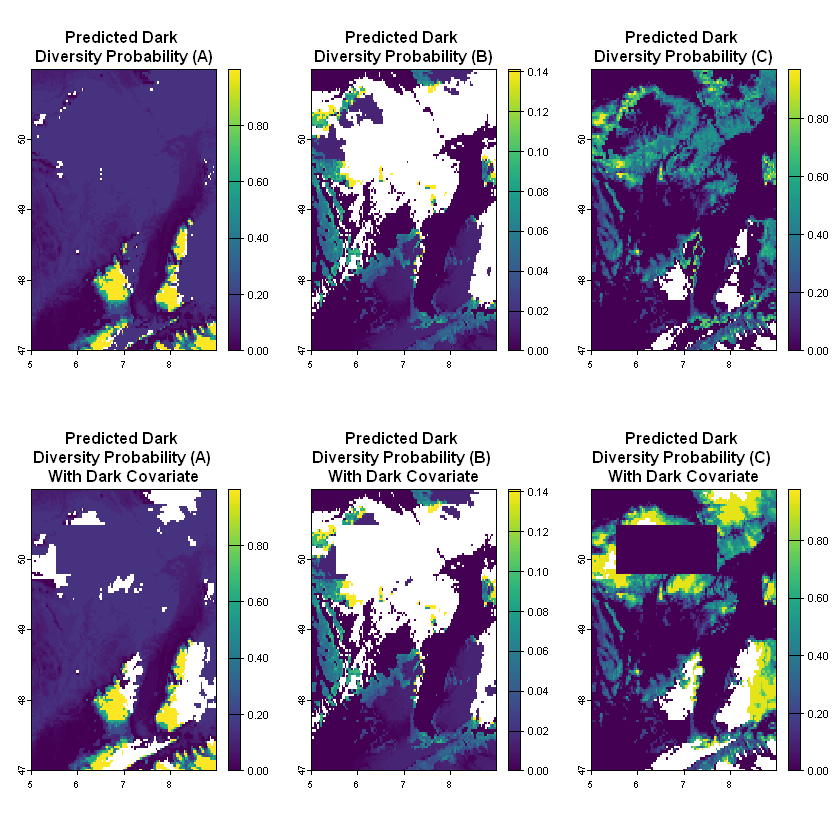

In [13]:
k <- 10

knn_indices <- apply(distances, 1, function(x) order(x)[1:k])
# Calculate Unweighted Average
predicted_sp_a_dark_prob <- apply(knn_indices, 2, function(x) {
    mean(full_obs[x, "sp_a_dark_prob"], na.rm = TRUE)
})

sp_a_pred_raster_knn <- pred_raster
terra::values(sp_a_pred_raster_knn) <- predicted_sp_a_dark_prob

predicted_sp_b_dark_prob <- apply(knn_indices, 2, function(x) {
    mean(full_obs[x, "sp_b_dark_prob"],na.rm = TRUE)
})

sp_b_pred_raster_knn <- pred_raster
terra::values(sp_b_pred_raster_knn) <- predicted_sp_b_dark_prob

predicted_sp_c_dark_prob <- apply(knn_indices, 2, function(x) {
    mean(full_obs[x, "sp_c_dark_prob"], na.rm = TRUE)
})

sp_c_pred_raster_knn <- pred_raster
terra::values(sp_c_pred_raster_knn) <- predicted_sp_c_dark_prob

par(bg = "white", mfrow = c(2, 3))
plot(sp_a_pred_raster_knn, main = "Predicted Dark \nDiversity Probability (A)")
plot(sp_b_pred_raster_knn, main = "Predicted Dark \nDiversity Probability (B)")
plot(sp_c_pred_raster_knn, main = "Predicted Dark \nDiversity Probability (C)")

knn_indices_with_dark <- apply(distances_with_dark, 1, function(x) order(x)[1:k])
# Calculate Unweighted Average
predicted_sp_a_dark_prob_with_dark <- apply(knn_indices_with_dark, 2, function(x) {
    mean(full_obs[x, "sp_a_dark_prob"], na.rm = TRUE)
})

sp_a_pred_raster_knn_with_dark <- pred_raster
terra::values(sp_a_pred_raster_knn_with_dark) <- predicted_sp_a_dark_prob_with_dark

predicted_sp_b_dark_prob_with_dark <- apply(knn_indices_with_dark, 2, function(x) {
    mean(full_obs[x, "sp_b_dark_prob"], na.rm = TRUE)
})

sp_b_pred_raster_knn_with_dark <- pred_raster
terra::values(sp_b_pred_raster_knn_with_dark) <- predicted_sp_b_dark_prob_with_dark

predicted_sp_c_dark_prob_with_dark <- apply(knn_indices_with_dark, 2, function(x) {
    mean(full_obs[x, "sp_c_dark_prob"], na.rm = TRUE)
})

sp_c_pred_raster_knn_with_dark <- pred_raster
terra::values(sp_c_pred_raster_knn_with_dark) <- predicted_sp_c_dark_prob_with_dark

plot(sp_a_pred_raster_knn_with_dark, main = "Predicted Dark \nDiversity Probability (A) \nWith Dark Covariate")
plot(sp_b_pred_raster_knn_with_dark, main = "Predicted Dark \nDiversity Probability (B) \nWith Dark Covariate")
plot(sp_c_pred_raster_knn_with_dark, main = "Predicted Dark \nDiversity Probability (C) \nWith Dark Covariate")


From the above plots, we can can see that the inclusion of the dark diversity covariate leads to worse predictions of dark diversity. There areas where there are no-data values, there are where the species is observed, and so the dark diversity probability is `NA`.

## 3.2 Using a GAM

1. Build GAM Model: Build a separate GAM model for each species' dark diversity probability (sp_a_dark_prob, sp_b_dark_prob, sp_c_dark_prob). The GAM will have the following structure:

```
gamm4(sp_a_dark_prob ~ s(env_1) + s(env_2), data = full_obs)
```

s(env_1) and s(env_2): Smooth terms for the environmental predictors.

2. Predict Dark Diversity Probabilities: Use the trained GAM models to predict the dark diversity probabilities at the locations of your prediction_grid points.

In [14]:
dark_mod_a_gam <- gamm4::gamm4(sp_a_dark_prob ~ s(env_1) + s(env_2), data = full_obs)
dark_mod_b_gam <- gamm4::gamm4(sp_b_dark_prob ~ s(env_1) + s(env_2), data = full_obs)
dark_mod_c_gam <- gamm4::gamm4(sp_c_dark_prob ~ s(env_1) + s(env_2), data = full_obs)

dark_mod_a_gam_with_dark <- gamm4::gamm4(sp_a_dark_prob ~ s(env_1) + s(env_2) + dark_env, data = full_obs)
dark_mod_b_gam_with_dark <- gamm4::gamm4(sp_b_dark_prob ~ s(env_1) + s(env_2) + dark_env, data = full_obs)
dark_mod_c_gam_with_dark <- gamm4::gamm4(sp_c_dark_prob ~ s(env_1) + s(env_2) + dark_env, data = full_obs)

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



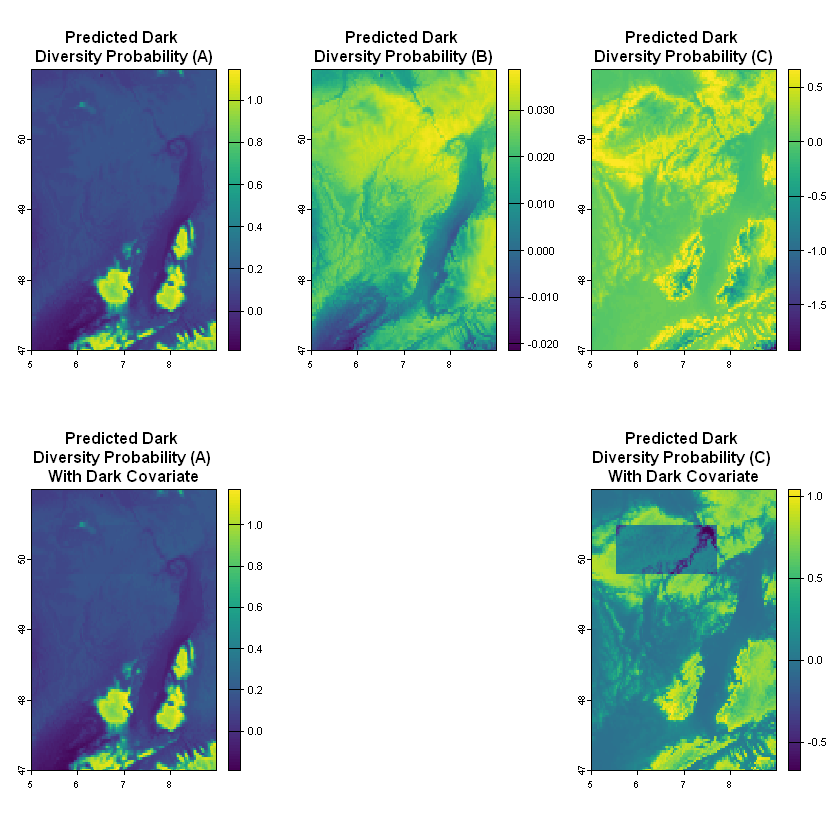

In [15]:
# Predict the dark diversity probability using the model
par(bg = "white", mfrow = c(2, 3))

dark_gam_a_pred <- predict(envs, dark_mod_a_gam$gam, type = "response")
dark_gam_b_pred <- predict(envs, dark_mod_b_gam$gam, type = "response")
dark_gam_c_pred <- predict(envs, dark_mod_c_gam$gam, type = "response")

dark_gam_a_pred_with_dark <- predict(envs, dark_mod_a_gam_with_dark$gam,
    type = "response"
)
dark_gam_b_pred_with_dark <- predict(envs, dark_mod_b_gam_with_dark$gam,
    type = "response"
)
dark_gam_c_pred_with_dark <- predict(envs, dark_mod_c_gam_with_dark$gam,
    type = "response"
)

# dark_gam_a_pred <- mask_pa(dark_gam_a_pred, true_a_pa)
# dark_gam_b_pred <- mask_pa(dark_gam_b_pred, true_b_pa)
# dark_gam_c_pred <- mask_pa(dark_gam_c_pred, true_c_pa)

plot(dark_gam_a_pred, main = "Predicted Dark \nDiversity Probability (A)")
plot(dark_gam_b_pred, main = "Predicted Dark \nDiversity Probability (B)")
plot(dark_gam_c_pred, main = "Predicted Dark \nDiversity Probability (C)")

plot(dark_gam_a_pred_with_dark, main = "Predicted Dark \nDiversity Probability (A) \nWith Dark Covariate")
plot(dark_gam_b_pred_with_dark, main = "Predicted Dark \nDiversity Probability (B) \nWith Dark Covariate")
plot(dark_gam_c_pred_with_dark, main = "Predicted Dark \nDiversity Probability (C) \nWith Dark Covariate")

The spatial pattern of the GAM model of dark diversity is similar to the KNN method, though given the nature of a GAM model, the output is both more smooth and predicts where the species is observed instead of returning `NA`.

Again, when the dark diversity covariate is included, the model pattern is worse (the rectangular area should have higher dark diversity probabilities, not lower).

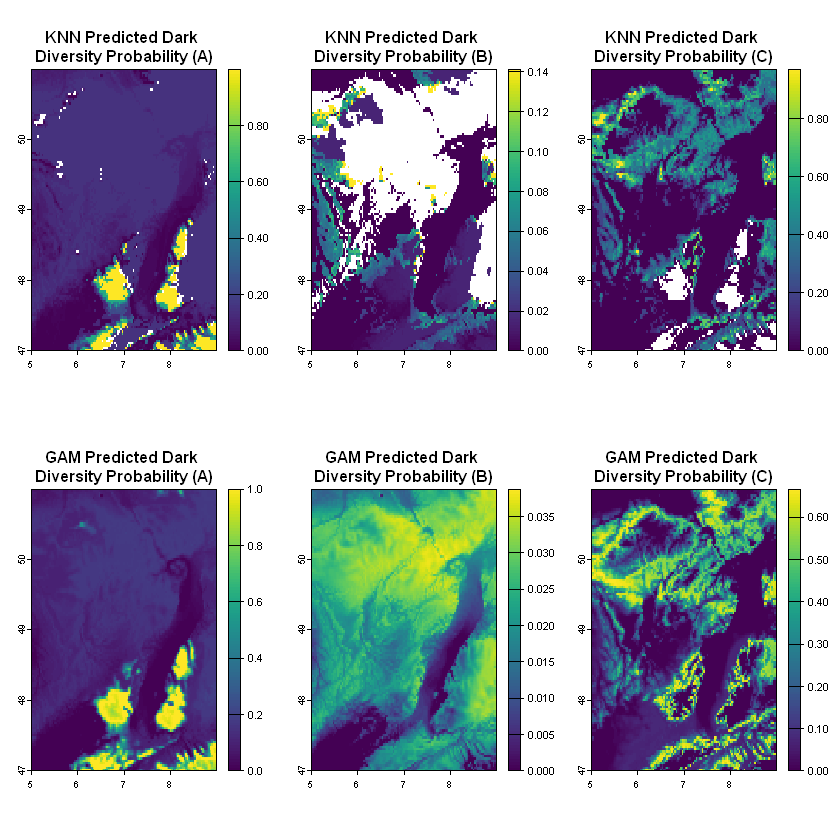

In [16]:
# Comparing the KNN with the GAM
par(bg = "white", mfrow = c(2, 3))

plot(sp_a_pred_raster_knn, main = "KNN Predicted Dark \nDiversity Probability (A)")
plot(sp_b_pred_raster_knn, main = "KNN Predicted Dark \nDiversity Probability (B)")
plot(sp_c_pred_raster_knn, main = "KNN Predicted Dark \nDiversity Probability (C)")

plot(clamp(dark_gam_a_pred, 0, 1, values = TRUE),
    main = "GAM Predicted Dark \nDiversity Probability (A)"
)
plot(clamp(dark_gam_b_pred, 0, 1, values = TRUE),
    main = "GAM Predicted Dark \nDiversity Probability (B)"
)
plot(clamp(dark_gam_c_pred, 0, 1, values = TRUE),
    main = "GAM Predicted Dark \nDiversity Probability (C)"
)

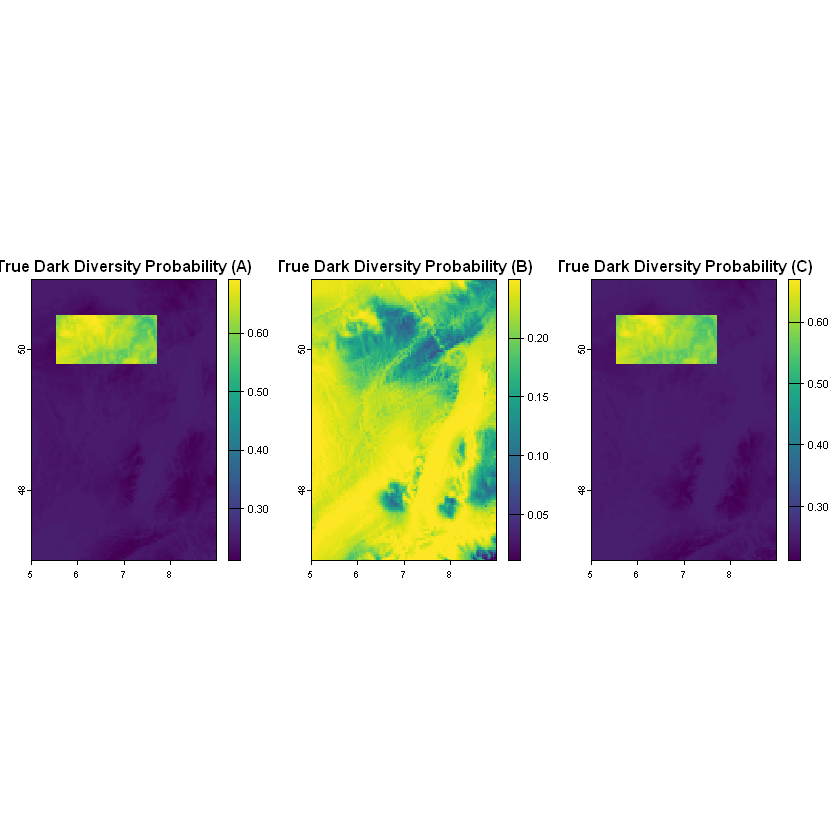

In [17]:
# Comparing with the true dark diversity as originally calculated
par(bg = "white", mfrow = c(1, 3))


plot(prob_missing_a, main = "True Dark Diversity Probability (A)")
plot(prob_missing_b, main = "True Dark Diversity Probability (B)")
plot(prob_missing_c, main = "True Dark Diversity Probability (C)")

# 4. Conclusion

The results from this simulation shows that the dark diversity can be calculated and spatially interpolated using an environmental matching method. However, when comparing the predicted dark diversity to the true dark diversity as defined, the correspondence is poor. 

This is likely due to the fact that the dark diversity is driven and defined by the dark diversity covariate. However, when the covariate is included in the model, the predictions are worse (i.e. dark diversity probabilities are lower where they should be higher). We know this is true because it has been defined to be so. However, in reality, the relationship between environmental variables and dark diversity is both unknown and likely to be complex.

However, this may also be a constraint of this simulation study. When 10000 points are sampled across the landscape, the dark diversity area does not show up in the direct calculations either. This may indicate that the amount of species co-occurrence in the simulated data is insufficient, and may be improved with more species with a greater diversity of distribution (see appendix 1.)

Methodologically, a GAM may be the best method for environmentally matching dark diversity probabilities, as it is able to predict where the species is observed and where it is not, as well as being significantly faster than the KNN method (KNN takes around 2-3 minutes for the simulated data with only 100 sampled points, which will increase significantly with larger rasters and more sampled points).

## 4. 1 Next steps

A further simulation study will be conducted with more species and a greater diversity of distributions.

# Appendix

## 1. Mapping the "true" dark diversity from DarkDiv
This uses many thousands of points across the landscape to fill a raster with the dark diversity probabilities, to get as close to the "true" dark diversity as possible calculated from species co-occurrence.

We can see from these estimates that the rectangle of dark diversity does not show up as intended. This may be due to the fact that the species distributions are not diverse enough, and the co-occurrence is not high enough to detect the dark diversity.

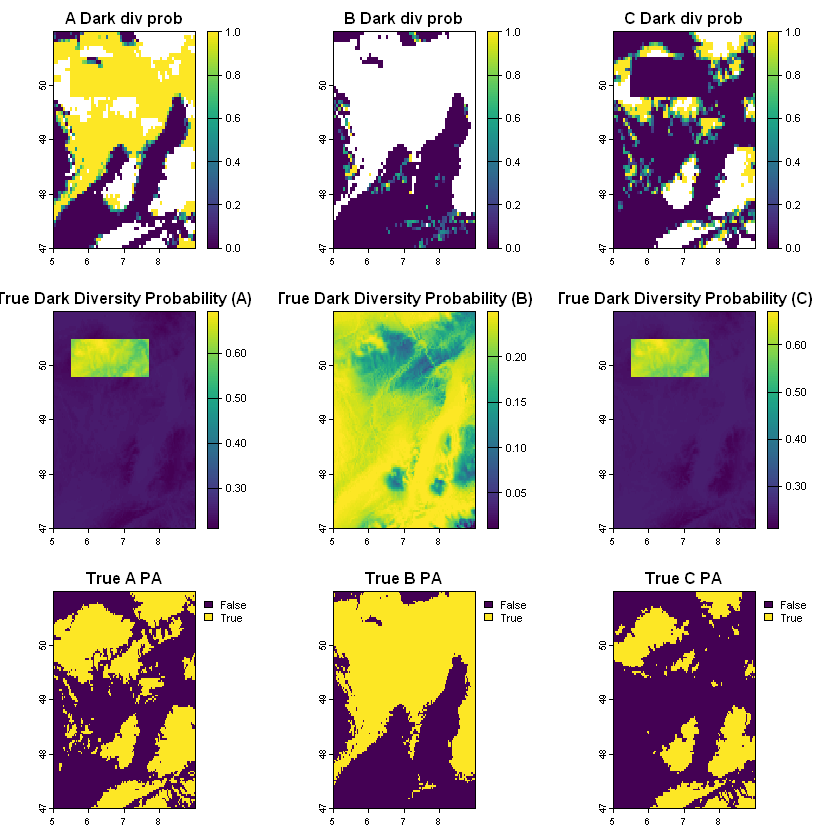

In [18]:
# Get observations

# Sample observations from the real presence absence
species_a_obs <- ifelse(terra::extract(obs_a_dist_prob, all_plots)[, 2] > threshold, 1, 0)
species_b_obs <- ifelse(terra::extract(obs_b_dist_prob, all_plots)[, 2] > threshold, 1, 0)
species_c_obs <- ifelse(terra::extract(obs_c_dist_prob, all_plots)[, 2] > threshold, 1, 0)

env_1_obs <- terra::extract(env_1, all_plots)[, 2]
env_2_obs <- terra::extract(env_2, all_plots)[, 2]
dark_env_obs <- terra::extract(dark_env, all_plots)[, 2]

# Create a data frame with the observations
all_plot_observations <- data.frame(
    species_a_pa = species_a_obs,
    species_b_pa = species_b_obs,
    species_c_pa = species_c_obs,
    env_1 = env_1_obs,
    env_2 = env_2_obs,
    dark_env = dark_env_obs
)

# Calculate the dark diversity probability for each plot

# Using PA
all_dd_pa <- DarkDiv::DarkDiv(all_plot_observations[1:3])$Dark
all_dd_pa_zerofilled <- ifelse(is.nan(all_dd_pa), 0, all_dd_pa)

colnames(all_dd_pa_zerofilled) <- c("sp_a_dark_prob", "sp_b_dark_prob", "sp_c_dark_prob")

all_plots$dd_pa_a <- all_dd_pa_zerofilled[,1]
all_plots$dd_pa_b <- all_dd_pa_zerofilled[,2]
all_plots$dd_pa_c <- all_dd_pa_zerofilled[,3]

template_rast <- terra::aggregate(env_1, 2)

# Plotting the point estimates for dark diversity probability for each species
all_sp_a_dd_pa_raster <- terra::rasterize(all_plots,template_rast, field = "dd_pa_a", fun = function(x) mean(x, na.rm = TRUE))
all_sp_b_dd_pa_raster <- terra::rasterize(all_plots,template_rast, field = "dd_pa_b", fun = function(x) mean(x, na.rm = TRUE))
all_sp_c_dd_pa_raster <- terra::rasterize(all_plots, template_rast, field = "dd_pa_c", fun = function(x) mean(x, na.rm = TRUE))

par(bg = "white", mfrow = c(3, 3))  # Set the background color and layout
plot(all_sp_a_dd_pa_raster, main = "A Dark div prob")
plot(all_sp_b_dd_pa_raster, main = "B Dark div prob")
plot(all_sp_c_dd_pa_raster, main = "C Dark div prob")

# Plotting the true dark diversity probability for comparison
plot(prob_missing_a, main = "True Dark Diversity Probability (A)")
plot(prob_missing_b, main = "True Dark Diversity Probability (B)")
plot(prob_missing_c, main = "True Dark Diversity Probability (C)")

# Plotting the species presence absense
plot(true_a_pa, main = "True A PA")
plot(true_b_pa, main = "True B PA")
plot(true_c_pa, main = "True C PA")
